<a href="https://colab.research.google.com/github/paigejh13/ENPH353_Lab5/blob/main/ENPH353_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
## This code block  is used to draw dot graphs for visualization purposes
# functions include trace() and draw_dot()
#

from graphviz import Digraph

## used to build connections between nodes in a graph using a recursive structure
#  param root: the node you want to draw back from
#  returns a set of nodes and a set of edges for the graph
def trace(root):

  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

## used to draw a dot graph from a 'top' node. Each node is printed with a label
# blank, data blank, and a grad blank
#  param root: the node you want to draw back from
#  returns a set of nodes and a set of edges for the graph
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))


    dot.node(name=uid, label="{%s | data %.4f |grad %.4f}" % (n.label, n.data, n.grad), shape= 'record')
    if n._op:
      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid + n._op,uid)

  for n1, n2 in edges:
    n1_name = str(id(n1))
    n2_name = str(id(n2))
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot



In [107]:
## Class to define the structure of a node. All neurons/nodes in the eventual neural
#  network will be impletemented as Values under the hood.
#
#  Each Value instannce has a numerical value, set of children, backward
#  propogation function, gradient, label, and operation tag allowing us to also
#  create nodes for operations in a dot graph of the neural network
#  More details.

class Value:

  ## Constructor
  #  param data: the numerical value of the instance
  #  param children: list of child values (if applicable)
  #  param op: operation tag
  #  param label: Value label
  #
  #  creates new instance of the Value class

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0

  ## Overwrites pythons built in __repr__ function so when called, a Value instance
  #  only prints it numerical value to the terminal
  def __repr__(self):
    return f"Value(data={self.data})"

  ## Overwrites pythons built in __add__ function to allow the operation of adding
  #  one instance of the Value class to be added to an int/float or another Value
  #  instance
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    ## Defines the local partial derivative for addition operation and chains
    # that to the up stream/global derivative
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 *out.grad
    out._backward = _backward

    return out

  ## Overwrites pythons built in __mul__ function to allow the operation of multipling
  #  one instance of the Value class to be multiplied with an int/float or another Value
  #  instance
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    ## Defines the local partial derivative for multipliction operation and chains
    # that to the up stream/global derivative
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data *out.grad
    out._backward = _backward

    return out

  ## Overwrites pythons built in __pow__ function to allow the operation of raising
  #  one instance of the Value class to the power an int/float
  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    ## Defines the local partial derivative for exponent operation and chains
    # that to the up stream/global derivative
    def _backward():
      self.grad  += other*self.data**(other-1) * out.grad
    out._backward = _backward

    return out

  ## Overwrites pythons built in __truediv__ function to allow the operation of
  #  division of one instance of the Value class by an int/float or
  #  another Value instance
  def __truediv__(self, other):
    return self * other**-1

  ## Overwrites pythons built in __neg__ function to allow the operation of
  #  multiplying an instance of the value class by -1
  def __neg__(self):
    return self * -1

  ## Overwrites pythons built in __sub__ function to allow the operation of
  #  subtraction of one instance of the Value class from an int/float or
  #  another Value instance
  def __sub__(self, other):
    return self + (-other)

  ## Ensures that it does not matter which parameter in the mathematical operation
  #  functions is passed as an int/float (if any)
  def __rmul__(self, other):
    return self*other

  ## defines the tanh() for an instance of the Value class
  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')

    ## Defines the local partial derivative for addition operation and chains
    # that to the up stream/global derivative
    def _backward():
      self.grad  += (1-t**2)*out.grad
    out._backward = _backward

    return out

  ## defines the 2*tanh() for an instance of the Value class
  def two_tanh(self):
    n = self.tanh()*2
    n.grad = n.grad*2
    return n

  ## Overwrites pythons built in exp() function to allow the operation of raising
  #  e to the power of an instance of the Value class
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    ## Defines the local partial derivative for addition operation and chains
    # that to the up stream/global derivative
    def _backward():
      self.grad  += out.data * out.grad
    out._backward = _backward

    return out

  ## Defines the back propogation alogorithm for some network of Value instances
  #  starting with the node the function is called on and working backward
  def backward(self):
    topo = []
    visited = set()

    ## Defines a functions to builds a topological graph structure from the
    #  network of Value instances
    def build_topo(v):
      a = 1
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [108]:
#manualy populate the layers, and perform 1 backward pass using the
# tanh() function in the Value class as an activiation function

x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0 , label='w2')
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

o.backward()

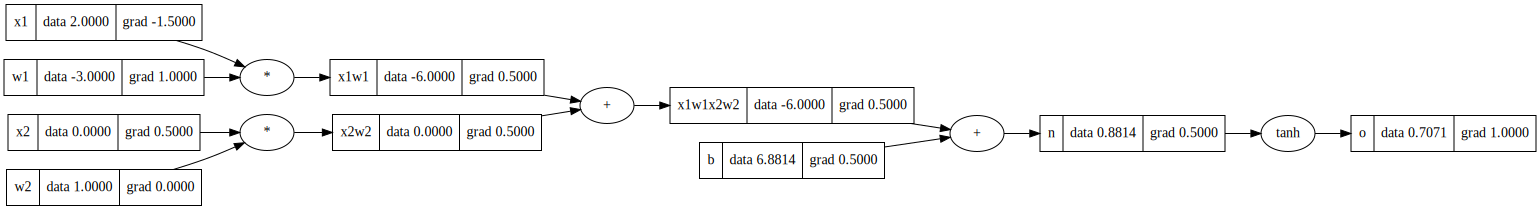

In [109]:
draw_dot(o)

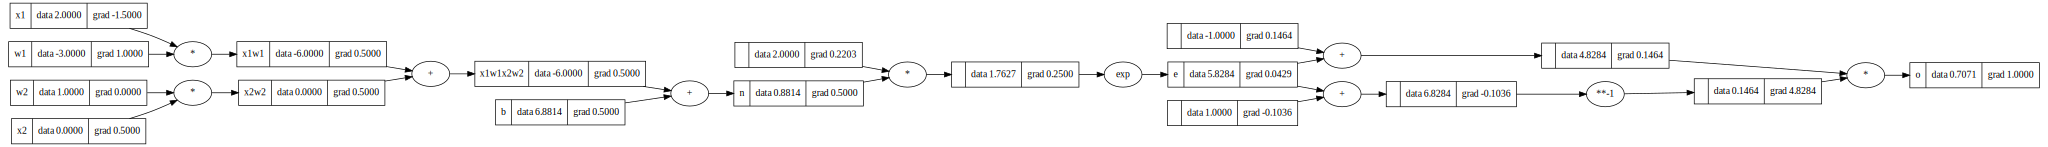

In [110]:
#manualy populate the layers, and perform 1 backward pass, manually
#implementing the tanh() function for the activiation function


x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0 , label='w2')
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp(); e.label='e'
g = (e - 1)/(e + 1); g.label='g'

g.label='o'

g.backward()
draw_dot(g)

In [111]:
#create the neural network using the PyTorch Library instead
#of by hand


from torch.storage import T
import torch
import random

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('___')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071050214706146
___
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [159]:
from ast import FunctionDef

## Class that defines the structure of a neuron, including weights and bias
# values for a specific instance of the class, as well as the functionality to
#  select an activation from a list of functions (this option is a work in progress)


class Neuron:

  ## Constructor
  #  param nin: number of inputs to the neuron
  #  param func: chosen activation function
  #
  #  creates new instance of the Neuron class
  def __init__(self, nin, func = 0.0):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    self.func = func

  ## Overwrites the buil in python function __call__ to perform the forward
  #  propogation step for one specfic neuron
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.two_tanh()
    return out

  ## Returns a list of all weights and biases of one Neuron instance
  def parameters(self):
    return self.w +[self.b]

## Class that defines the structure of a neuron layer, keeping a list of
#  Neuron instances in a specific layer of a network

class Layer:

  ## Constructor
  #  param nin: number of inputs neurons to the Layer instance
  #  param nout: the number of neurons in Layer instance
  #
  #  creates new instance of the Layer class
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  ## Overwrites the buil in python function __call__ to perform the forward
  #  propogation step for one specfic layer in a network
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  ## Returns a list of all weights and biases of one Layer instance
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

## Class that defines the structure of a neural network from a integer number of
#  inputs, layers, and neurons in each layer, along with a specified activation
#  function
class MLP:

  ## Constructor
  #  param nin: number of inputs neurons to the MLP instance
  #  param nout: the number of neurons in output layer of the MLP instance
  #
  #  creates new instance of the MLP class
  def __init__(self, nin, nouts, func = 0):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    self.func = func

  ## Overwrites the buil in python function __call__ to perform the forward
  #  propogation step for the whole MLP instance( the whole neural network)
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    #set the activation function of all neurons to chosen function
    for i in n.layers:
      for j in i.neurons:
        j.func = self.func
    return x

  ## Returns a list of all weights and biases of one MLP instance
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

def listsum(list):
  sum = 0
  for i in range(0, len(list)):
    sum = list[i] + sum
  return sum

In [113]:
##Test case set up

xs =[
    [2.0, 3.0, -1,0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
n = MLP(3, [4, 4, 1])

ypred = [n(x) for x in xs]
ypred

[Value(data=0.7420368005175461),
 Value(data=0.3974686546774536),
 Value(data=0.3824122625339033),
 Value(data=0.6942362851206565)]

In [114]:
#Test case training

for k in range(50):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 *p.grad

  print(k, loss.data)


0 4.024018766034158
1 5.916645870455203
2 0.5873693374107172
3 0.30571914656169213
4 0.19662080989973435
5 0.14161405954346953
6 0.10906449147077142
7 0.08782867119866049
8 0.07301116658607869
9 0.06215297479943171
10 0.05389386659076119
11 0.04742473881354323
12 0.042236266226270636
13 0.03799293162375174
14 0.03446532448696761
15 0.031491627694042616
16 0.02895465033124759
17 0.026767575350386073
18 0.024864809045209924
19 0.023195930466868974
20 0.021721586260805267
21 0.020410641463142476
22 0.019238161702081764
23 0.018183958174681318
24 0.01723152125705439
25 0.016367227373441373
26 0.015579741166479179
27 0.014859559344170164
28 0.014198658711336399
29 0.013590221778473969
30 0.013028420805026078
31 0.012508246328928392
32 0.012025369899680657
33 0.011576033351533012
34 0.011156958847404605
35 0.0107652753088676
36 0.010398457870342291
37 0.01005427775844115
38 0.009730760571433527
39 0.009426151369464484
40 0.009138885319457422
41 0.008867562895543139
42 0.008610928835307199
43

In [115]:
#attempt to train network to match ys outputs
xs = [[2.0], [3.0], [4.0]]
ys = [2.0, -1.0, -2.0]
n = MLP(1, [4, 4, 1])

ypred = [n(x) for x in xs]
ypred


[Value(data=0.17743939119890764),
 Value(data=0.08424087531953003),
 Value(data=0.06636068178991204)]

In [116]:
#attempt to train with learning rate of 0.1 and tanh() as an activation function
for k in range(300):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 *p.grad

  if k%5 == 0:
    print(k, loss.data)

  #The network doesnt converge for this step size, it is too large and the
  #network appears confused

0 8.76715191571434
5 13.725314715989752
10 8.758681569343988
15 7.0507307130859145
20 9.664495741078824
25 11.427345577354608
30 9.570343658125992
35 8.280614294955663
40 13.337106806396122
45 9.67673123816181
50 13.171815828511164
55 9.1464742149284
60 3.338296522096221
65 6.378751599202768
70 9.929964494207907
75 9.812555631665662
80 13.473367880070327
85 8.564388014405022
90 8.35069509846709
95 9.737677751485261
100 8.611441607446801
105 8.520039869846151
110 8.71307450519328
115 9.63862529795749
120 8.644000952052108
125 8.623786185947003
130 8.587682536936097
135 8.394216077403915
140 9.495481233011063
145 9.915623139252961
150 9.649981966273346
155 9.97388122902589
160 9.965648879561606
165 9.950260706140687
170 9.912498371661956
175 9.72802781999201
180 8.758431306421915
185 8.713536666740206
190 8.746270246053415
195 8.706000285059828
200 8.734243195304147
205 8.694059450579775
210 8.720679411124777
215 8.669901969154456
220 8.741074975433795
225 8.581363098041445
230 8.9066078

In [144]:
#attempt to train the network using different hyper parameters to imporve performace
xs = [[2.0], [3.0], [4.0]]
ys = [2.0, -1.0, -2.0]
m = MLP(1, [4, 4, 1])

ypred = [m(x) for x in xs]
ypred

[Value(data=-0.9831886881647928),
 Value(data=-0.9802425369653928),
 Value(data=-0.9786347249531757)]

In [150]:
#reduce step size to 0.02

for k in range(300):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.02 *p.grad

  if k%20 == 0:
    print(k, loss.data)

  #This step size is better but tanh is bounded between -1 and 1 so the last layer
  # of the network will never output -2 or 2, therefore using tanh() will
  # approach 2  - (-2 - (-1))^2  + (2 - 1)^2

0 2.0035764546366552
20 2.003536663331011
40 2.003497742811849
60 2.0034596648715652
80 2.003422402506259
100 2.003385929852254
120 2.003350222126598
140 2.003315255571248
160 2.0032810074006626
180 2.0032474557525974
200 2.003214579641843
220 2.003182358916713
240 2.003150774218111
260 2.0031198069409673
280 2.003089439197912


In [160]:
# attempt 3 to modify network so loss approaches 0
xs = [[2.0], [3.0], [4.0]]
ys = [2.0, -1.0, -2.0]
nn = MLP(1, [4, 4, 1], 1)

ypred = [nn(x) for x in xs]
ypred

[Value(data=0.2546302284350278),
 Value(data=0.1286201093987355),
 Value(data=-0.3145375431020453)]

In [162]:
# change activation function to 2*tanh()
for k in range(300):

  #forward pass
  ypred = [nn(x) for x in xs]
  loss = listsum([(yout - ygt)**2 for yout, ygt in zip(ypred, ys)])

  #backward pass
  for p in nn.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in nn.parameters():
    p.data += -0.001 *p.grad

  if k %20 == 0:
    print(k, loss.data)

for a in nn.parameters():
  if abs(a.data) > 1:
    print(a)

  #By changing the activiation function to 2*tanh instead of tanh(, the target
  #output values are now in the range of the activation function and the network
  # is able to fully minimize the cost function

0 0.06305814899514665
20 0.058824160564551066
40 0.05512163627080587
60 0.051856746941632656
80 0.04895644227362586
100 0.04636302166179504
120 0.0440303168347197
140 0.0419209561498058
160 0.04000437015650313
180 0.03825531485690015
200 0.03665276277817875
220 0.03517905948025979
240 0.0338192743722873
260 0.0325606956466878
280 0.03139243340160122
Value(data=1.0888604003728712)
Value(data=-1.042781921157535)
Value(data=1.142847529843836)
Value(data=-1.018229520256042)
Value(data=-1.230688187696219)
